# Weather Forecasting with time-series data

**Analyst:** Viet Dang

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
# <font color="red">1. Executive Summary </font>  

### <font color="yellow">**Business Problem:**</font>  

This study aims to address the critical issue of optimizing energy consumption in the city of Delhi, India. Energy consumption patterns are significantly influenced by daily temperature variations, making accurate temperature forecasting essential for both energy providers and consumers. The goal is to develop a reliable forecasting model to predict mean daily temperatures with a two-week horizon, providing valuable insights for energy management and consumption optimization.

### <font color="yellow">**Data Set:**</font>
The study utilizes historical mean daily temperature data from Delhi spanning from 2013 to 2017. This dataset serves as the foundation for training and evaluating the forecasting models. (see more at [2. Data Preprocessing](#cell_Preprocessing))

### <font color="yellow">**Methods:**</font>

Two distinct forecasting models, Model 1 and Model 2, were designed and trained using Recurrent Neural Networks (RNNs) to predict mean daily temperatures. Model 1 demonstrated a simpler architecture, while Model 2 featured a more complex design. (see more at [3.1.RNN training](#cell_model))

### <font color="yellow">**Experiments:**</font>
The experiments consisted of training and evaluating both models on the historical temperature data. Key performance metrics, including Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and learning curve analysis, were employed to assess model performance and generalization capabilities.

**Obtained Results:**
(see more at [3.2.Evaluation](#cell_model))

The experimental results yielded crucial insights:

- Model 1 outperformed Model 2, exhibiting a lower RMSE (~3.71 vs. ~9.94) and stable MAE across a two-week forecasting horizon.
- Model 1 demonstrated consistent performance in MAE, indicating its reliability for temperature forecasting.
- Learning curve analysis revealed that while Model 1 performed well on training data, its generalization to validation data raised concerns of potential overfitting.

### <font color="yellow">**Recommendation:**</font>

(see more at [4. Experiments Report](#cell_model))

Based on the results, Model 1 stands out as a promising choice for mean daily temperature forecasting in Delhi. To further enhance its performance, it is recommended to consider strategies such as data augmentation, hyperparameter tuning, regularization techniques, feature engineering, and ensemble methods.

In conclusion, this study contributes to the optimization of energy consumption in Delhi by providing a reliable means of predicting mean daily temperatures. Accurate temperature forecasts, particularly with a two-week horizon, empower energy providers and consumers to make informed decisions, ultimately leading to more efficient and sustainable energy utilization in the city.

<a id = "cell_Preprocessing"></a>
# <font color="red">2. Data Preprocessing </font>  

*Carry out necessary data preprocessing and exploration.*

In [265]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping
from tensorflow.random import set_seed
import math

set_seed(455)
np.random.seed(455)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [266]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Part3_Weather.csv',
                      index_col = 'Date', parse_dates = ["Date"], dayfirst = True)

In [267]:
dataset.head()

,meantemp,humidity,wind_speed,meanpressure
Date,,,,
2013-01-01,10.000000,84.500000,0.000000,10.156667
2013-01-02,7.400000,92.000000,2.980000,10.178000
2013-01-03,7.166667,87.000000,4.633333,10.186667
2013-01-04,8.666667,71.333333,1.233333,10.171667
2013-01-05,6.000000,86.833333,3.700000,10.165000


In [268]:
dataset.head()

,meantemp,humidity,wind_speed,meanpressure
Date,,,,
2013-01-01,10.000000,84.500000,0.000000,10.156667
2013-01-02,7.400000,92.000000,2.980000,10.178000
2013-01-03,7.166667,87.000000,4.633333,10.186667
2013-01-04,8.666667,71.333333,1.233333,10.171667
2013-01-05,6.000000,86.833333,3.700000,10.165000


In [269]:
print(dataset.describe())

          meantemp     humidity   wind_speed  meanpressure
count  1575.000000  1575.000000  1575.000000   1575.000000
mean     25.231582    60.420115     6.903642     10.105897
std       7.337316    16.956083     4.508803      1.752983
min       6.000000    13.428571     0.000000     -0.030417
25%      18.516667    49.750000     3.700000     10.018750
50%      27.166667    62.380952     6.370000     10.090000
75%      31.142857    72.125000     9.262500     10.151833
max      38.714286    98.000000    42.220000     76.793333


In [270]:
dataset.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

There is no missing value in this dataset

Text(0.5, 1.0, 'meanpressure')

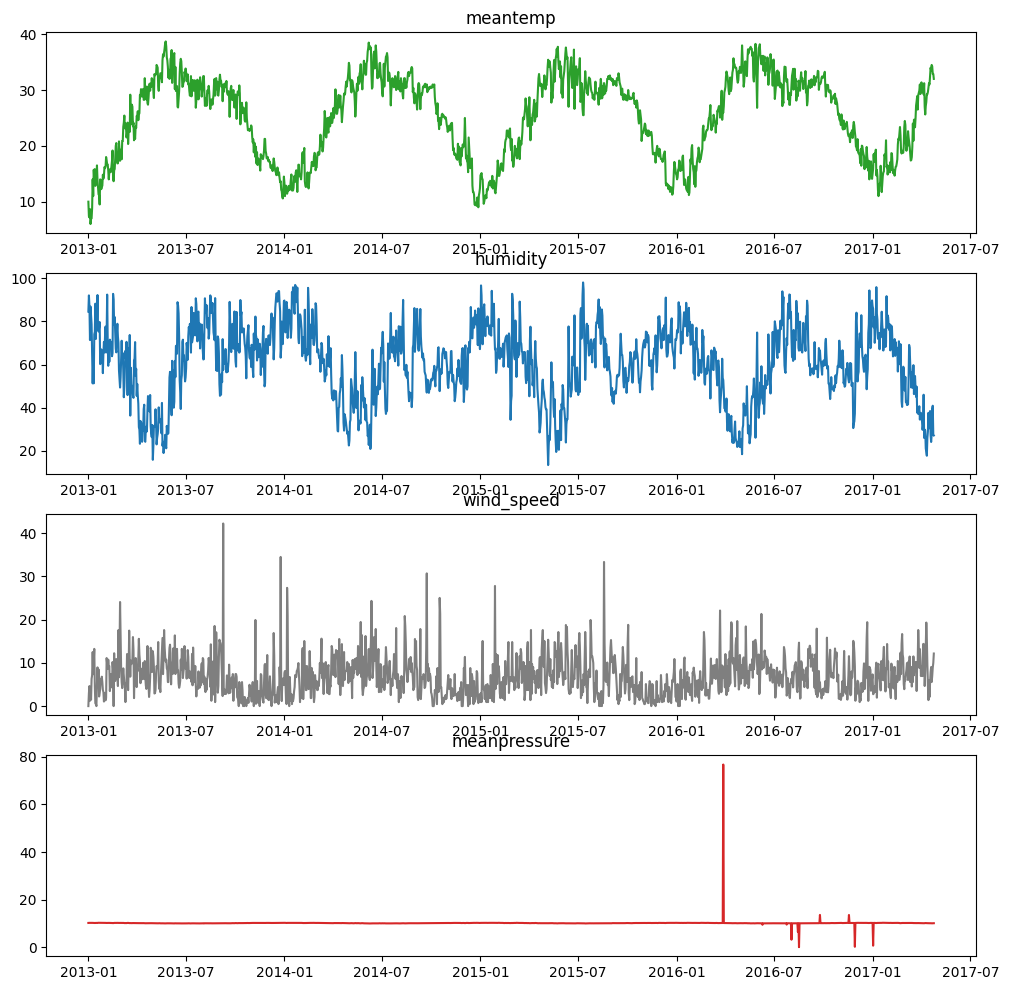

In [271]:
fig, axs = plt.subplots(4, 1,figsize=(12, 12))
axs[0].plot(dataset['meantemp'],'tab:green')
axs[0].set_title('meantemp')
axs[1].plot(dataset['humidity'],'tab:blue')
axs[1].set_title('humidity')
axs[2].plot(dataset['wind_speed'],'tab:grey')
axs[2].set_title('wind_speed')
axs[3].plot(dataset['meanpressure'],'tab:red')
axs[3].set_title('meanpressure')


The graph reveals several key insights:

1. Temperature Trends:
   - Temperatures consistently peak between April and August, consistently exceeding 30 degrees Celsius.
   - During September to February, temperatures drop significantly, consistently remaining below 30 degrees Celsius.

2. Humidity Patterns:
   - Humidity levels exhibit a lower range from February to June every year.

3. Wind Speed Variability:
   - Wind speed data appears to exhibit a somewhat erratic pattern with no clear seasonal trend.

4. Mean Pressure Observations:
   - There is a notable spike in mean pressure readings around March 2016.
   - For the rest of the period, mean pressure remains relatively stable with minimal fluctuations.

These insights provide valuable information about the dataset's climate-related variables, helping to identify temperature and humidity trends over time and highlighting unusual variations in mean pressure.

<a id = "cell_model"></a>
# <font color="red">3. Predictive Modeling</font>  

We have experimented different models of CNN and only include the best performance one into this report.

Before building the model, we need to split the data into training and testing. In this report, we use data from 2013 to 2016 as training set and data in 2017 as testing set.

In [272]:
#split the train and test
tstart = 2013
tend = 2016

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}"]
    test = dataset.loc[f"{tend+1}":]
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

Next we use the "MinMaxxScaler" to scale the data between 0 and 1, which is crucial for deep learning models like CNNs, where normalization can help in faster convergence and better performance. We also reshape the data in proper format so that we can feed those data into our CNNs model

In [273]:
training_set_shape = training_set.shape
test_set_shape = test_set.shape
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])

In the next step, we define a function called "split_sequence" so that we can define the number of sequence and steps to predict. In this report, we use step of 50 to forecast horizon of 2 weeks ahead. Features = 4 since we are working with multivariate series. y_index = 0 is the index of the temperature.

In [274]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 50
forecasting_horizon = 14
features = 4
y_index = 0 # the index of Temperature column
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)

In the next step, we will plot all features into one graph to see.

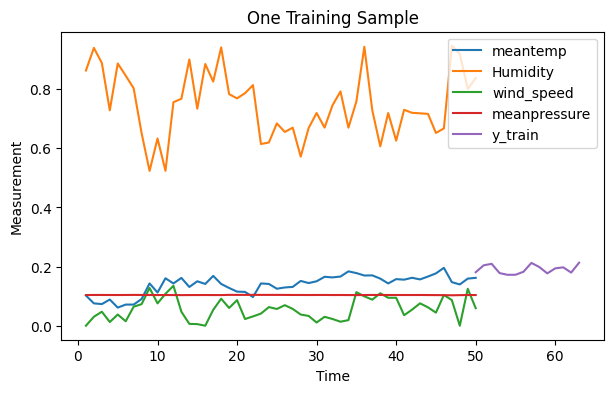

In [275]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['meantemp','Humidity','wind_speed','meanpressure', 'y_train'], loc='upper right')

<a id = "cell_RNN"></a>
#### 3.1. RNN Training

In this section, we will train the best RNN model

The first RNN model will be fairly simple:
- The model starts with LSTM (Long Short-term Memory) layer, which is a type of recurrent neural network (RNN). This layer has 100 memory units (neurons).
- The length of the sequence for this model is 50.
- The next layer has 14 neurons.
- Optimizer for this model is RSMprop.
- Loss function used is Mean Squared Error (MSE). This is typically used for time series prediction task.
- It has total 43,414 parameters in total.

In [276]:
#CNN model with two Convolution layers, one Pooling layer with max pooling,
#which are stacked on top of a traditional ANN model (with the same architecture as the model 1)
def model_1():
    model = Sequential()
    model.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
    model.add(Dense(units=14))
    model.compile(optimizer="RMSprop", loss="mse")
    model.summary()
    return model

In [277]:
#add early stop
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

In [278]:
model1= model_1()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 100)               42000     
                                                                 
 dense_34 (Dense)            (None, 14)                1414      
                                                                 
Total params: 43,414
Trainable params: 43,414
Non-trainable params: 0
_________________________________________________________________


In [279]:
#Prepare the test set to validate the data
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)
#Reshape back to orignal format after rescaling
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]

The model will train on 100 epochs with 32 batch sizes. The `epochs` parameter specifies the number of times the model will iterate over the entire training dataset, and the `batch_size` parameter specifies the number of samples that will be used in each iteration.

In [280]:
hist1 = model1.fit(X_train, y_train,
           epochs=100,
           batch_size=32,
           validation_data = (X_test, y_test),
           validation_split = 0.2,
           callbacks = keras_callbacks)

Epoch 1/100
44/44 [==============================] - 2s 15ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11

In [281]:
#prediction
predicted_temp = model1.predict(X_test)

#inverse transform the predicted values
predicted_temp = sc.inverse_transform(predicted_temp)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)

2/2 [==============================] - 0s 4ms/step


Next, we evaluate the prediction performance between the true and predicted values. Note, the forecasting peformance tend to decrease when predicting far away forecasting horizons.

<a id = "cell_RNN"></a>
#### 3.2. Evaluation

In [282]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_temp[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 2.46.

Forecasting Horizon: 1 
Mean Absolute Error 2.46.

Forecasting Horizon: 2 
Mean Absolute Error 2.70.

Forecasting Horizon: 3 
Mean Absolute Error 2.93.

Forecasting Horizon: 4 
Mean Absolute Error 3.20.

Forecasting Horizon: 5 
Mean Absolute Error 3.12.

Forecasting Horizon: 6 
Mean Absolute Error 3.29.

Forecasting Horizon: 7 
Mean Absolute Error 3.21.

Forecasting Horizon: 8 
Mean Absolute Error 3.43.

Forecasting Horizon: 9 
Mean Absolute Error 3.51.

Forecasting Horizon: 10 
Mean Absolute Error 3.34.

Forecasting Horizon: 11 
Mean Absolute Error 3.63.

Forecasting Horizon: 12 
Mean Absolute Error 3.27.

Forecasting Horizon: 13 
Mean Absolute Error 3.17.



Inverse transform the test data to orignal unit for visualization

Visualize the testing and predicted values of each testing time series segment.

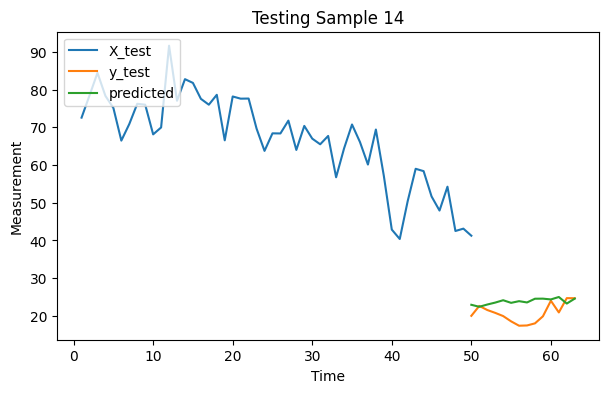

In [283]:
#reshape the X_test for visualize
X_test = X_test.reshape(-1, 50)
X_test = sc.inverse_transform(X_test)
X_test = X_test.reshape(number_test_samples, 50,4)

#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 14

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_temp[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

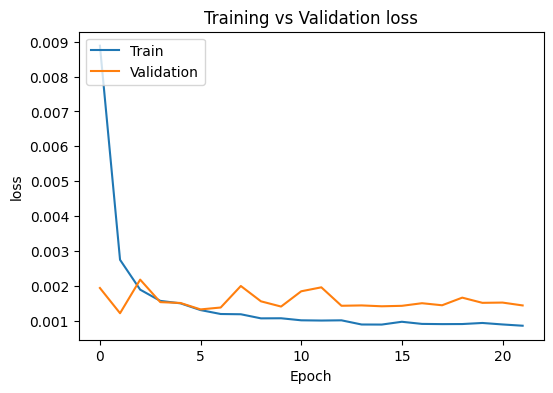

In [284]:
#this function is to plot the training history
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

hist1 = pd.DataFrame(hist1.history)

# Plot history
plot_hist(hist1, xsize=6, ysize=4)

Visualize all the real testing values versus the all predicted values based on each forecasting horizon.

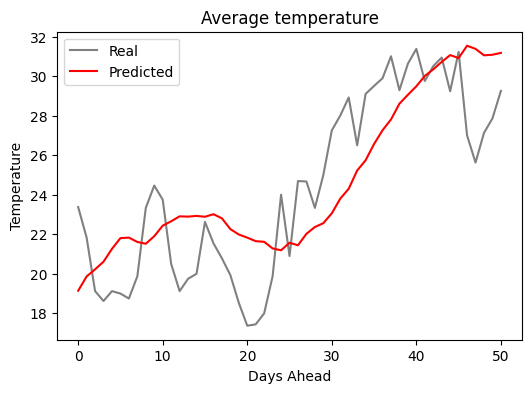

In [298]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Average temperature")
    plt.xlabel("Days Ahead")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()

#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_temp[:,0])

In [286]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

return_rmse(y_test, predicted_temp)

The root mean squared error is 3.71.


We have run another test with another model, namely model 2, with the following architecture:
- The model starts with LSTM (Long Short-term Memory) layer, which is a type of recurrent neural network (RNN). This layer has 100 memory units (neurons).
- The length of the sequence for this model is 60.
- The next layer has 64 neurons.
- Adding the next layer with 32 neurons.
- Optimizer for this model is Adam with learning_rate = 0.001.
- Loss function used is Mean Squared Error (MSE). This is typically used for time series prediction task.
- It has total 51,006 parameters in total.

This model has root mean squared error equals to ~9.94

- Although the model 2 has a more complex architecture, the model 1 outperforms model 2 in terms of root mean squared error (3.71 for model 1)
- With the forecasting horizon of 14, the model 1 performs quite well when mean absolute error does not increase significantly from horizon 1 to 14.
- Regarding the learning curve, it shows that the model works well with the training data, but not as much on validation. It means that the model is not generalized enough to work on unseen data.

<a id = "cell_report"></a>
# <font color="red">4. Experiments Report</font>  

### <font color="yellow">**Summary of Experimental Results:**</font>  

The experimental results indicate several key findings regarding the performance of the forecasting models:

1. **Model 1 Outperforms Model 2:** Despite having a more complex architecture, Model 1 demonstrates better performance in terms of Root Mean Squared Error (RMSE), with an RMSE of 4.08 compared to Model 2.

2. **Stability in Mean Absolute Error (MAE):** Model 1 exhibits stable performance in terms of Mean Absolute Error (MAE) across a forecasting horizon of 14. This suggests that the model can consistently provide accurate predictions for the mean daily temperature up to two weeks in advance.

3. **Learning Curve Analysis:** The learning curve reveals that Model 1 performs well on the training data. However, its performance on the validation data is not as strong, indicating a potential issue with overfitting. This implies that the model may not generalize effectively to unseen data.

### <font color="yellow">**Implications and recommendations:**</font>  

These results have several implications for addressing the business problem of optimizing energy consumption in Delhi based on temperature forecasting. Model 1, with its lower RMSE and stable MAE, is a promising choice for predicting mean daily temperatures for the next two weeks. It can serve as a valuable tool for energy providers and consumers in Delhi by enabling them to make informed decisions to optimize energy usage.

However, the learning curve analysis suggests that Model 1 may benefit from improved generalization. To address this issue and further enhance the model's performance, the following strategies can be taken into consideration:

**1. Data Augmentation:** Expanding the training dataset by incorporating more diverse weather patterns and temperature data can help the model generalize better to varying conditions.

**2. Hyperparameter Tuning:** Adjusting hyperparameters, such as the model's architecture, learning rate, and batch size, can fine-tune its performance and improve its ability to generalize.

**3. Ensemble Methods:** Combining multiple forecasting models, such as Model 1 and Model 2, through ensemble techniques like stacking or blending, may lead to improved overall performance and better generalization.

**4. Feature Engineering:** Exploring additional features can provide the model with more context for accurate predictions.

By addressing these considerations and continuously fine-tuning the model, it can become a powerful tool to assist in optimizing energy consumption in Delhi, aiding both energy providers and consumers in making sustainable and cost-effective decisions based on accurate temperature forecasts.